In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import time
import models
from utils import logger, write_log
torch.backends.cudnn.benchmark=True
from glob import glob
import importlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from models import DFFNet

In [26]:
import torch, os, sys, cv2
import torch.nn as nn
from torch.nn import init
import functools
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as func
from PIL import Image

import torchvision.transforms as transforms
import numpy as np
import torch

In [27]:
#dynamic architecture
class RecurrentBlock(nn.Module):

    def __init__(self, input_nc, output_nc, downsampling=False, bottleneck=False, upsampling=False):
        super(RecurrentBlock, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc

        self.downsampling = downsampling
        self.upsampling = upsampling
        self.bottleneck = bottleneck

        self.hidden = None

        if self.downsampling:
            self.l1 = nn.Sequential(
                    nn.Conv2d(input_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1)
                )
            self.l2 = nn.Sequential(
                    nn.Conv2d(2 * output_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1),
                    nn.Conv2d(output_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1),
                )
        elif self.upsampling:
            self.l1 = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv2d(2 * input_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1),
                    nn.Conv2d(output_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1),
                )
        elif self.bottleneck:
            self.l1 = nn.Sequential(
                    nn.Conv2d(input_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1)
                )
            self.l2 = nn.Sequential(
                    nn.Conv2d(2 * output_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1),
                    nn.Conv2d(output_nc, output_nc, 3, padding=1),
                    nn.LeakyReLU(negative_slope=0.1),
                )

    def forward(self, inp):

        if self.downsampling:
            op1 = self.l1(inp)
            op2 = self.l2(torch.cat((op1, self.hidden), dim=1))

            self.hidden = op2

            return op2
        elif self.upsampling:
            op1 = self.l1(inp)

            return op1
        elif self.bottleneck:
            op1 = self.l1(inp)
            op2 = self.l2(torch.cat((op1, self.hidden), dim=1))

            self.hidden = op2

            return op2

    def reset_hidden(self, inp, dfac):
        size = list(inp.size())
        size[1] = self.output_nc
        size[2] /= dfac
        size[3] /= dfac

        for s in range(len(size)):
            size[s] = int(size[s])

        self.hidden_size = size
        self.hidden = torch.zeros(*(size)).to('cuda:0')



class RecurrentAE(nn.Module):

    def __init__(self, input_nc):
        super(RecurrentAE, self).__init__()
        self.d1 = RecurrentBlock(input_nc=input_nc, output_nc=32, downsampling=True)
        self.d2 = RecurrentBlock(input_nc=32, output_nc=43, downsampling=True)
        self.d3 = RecurrentBlock(input_nc=43, output_nc=57, downsampling=True)
        self.d4 = RecurrentBlock(input_nc=57, output_nc=76, downsampling=True)
        self.d5 = RecurrentBlock(input_nc=76, output_nc=101, downsampling=True)

        self.bottleneck = RecurrentBlock(input_nc=101, output_nc=101, bottleneck=True)

        self.u5 = RecurrentBlock(input_nc=101, output_nc=76, upsampling=True)
        self.u4 = RecurrentBlock(input_nc=76, output_nc=57, upsampling=True)
        self.u3 = RecurrentBlock(input_nc=57, output_nc=43, upsampling=True)
        self.u2 = RecurrentBlock(input_nc=43, output_nc=32, upsampling=True)
        self.u1 = RecurrentBlock(input_nc=32, output_nc=1, upsampling=True)

    def set_input(self, inp):
        self.inp = inp['A']

    def forward(self):
        d1 = func.max_pool2d(input=self.d1(self.inp), kernel_size=2)
        d2 = func.max_pool2d(input=self.d2(d1), kernel_size=2)
        d3 = func.max_pool2d(input=self.d3(d2), kernel_size=2)
        d4 = func.max_pool2d(input=self.d4(d3), kernel_size=2)
        d5 = func.max_pool2d(input=self.d5(d4), kernel_size=2)

        b = self.bottleneck(d5)

        u5 = self.u5(torch.cat((b, d5), dim=1))
        u4 = self.u4(torch.cat((u5, d4), dim=1))
        u3 = self.u3(torch.cat((u4, d3), dim=1))
        u2 = self.u2(torch.cat((u3, d2), dim=1))
        u1 = self.u1(torch.cat((u2, d1), dim=1))

        return b

    def reset_hidden(self):
        self.d1.reset_hidden(self.inp, dfac=1)
        self.d2.reset_hidden(self.inp, dfac=2)
        self.d3.reset_hidden(self.inp, dfac=4)
        self.d4.reset_hidden(self.inp, dfac=8)
        self.d5.reset_hidden(self.inp, dfac=16)

        self.bottleneck.reset_hidden(self.inp, dfac=32)

        self.u4.reset_hidden(self.inp, dfac=16)
        self.u3.reset_hidden(self.inp, dfac=8)
        self.u5.reset_hidden(self.inp, dfac=4)
        self.u2.reset_hidden(self.inp, dfac=2)
        self.u1.reset_hidden(self.inp, dfac=1)

In [89]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=64,out_channels=32, kernel_size=5)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5)
        self.conv4 = torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5)
        self.lstm1 = torch.nn.LSTM(
            input_size= 346112,
            hidden_size=512,
            num_layers=2,
        )
        self.conv5 = torch.nn.Conv2d(in_channels=8, out_channels=1, kernel_size=5)
        self.fc2 = torch.nn.Linear(128, 6)

    def forward(self, x):
        b,s,h,w=x.shape
        print(x.shape)
        x=x.reshape(b*s,1,h,w)
        print(x.shape)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        print(x.shape)
        bs,c,h,w=x.shape
        x=x.reshape(b,s,c*h*w)
        print(x.shape)
        x,_ = self.lstm1(x)
        print(x.shape)
        x=x.reshape(bs,c,h,w)
        print(x.shape)
        x=self.conv5(x)
        print(x.shape)
        #x = x[:, -1, :]
        #x = self.fc2(x)
        return x

In [90]:
img=torch.rand((10,5,224,224))
model=CNNLSTM()
model(img).shape

torch.Size([10, 5, 224, 224])
torch.Size([50, 1, 224, 224])
torch.Size([50, 8, 208, 208])
torch.Size([10, 5, 346112])
torch.Size([10, 5, 512])


RuntimeError: shape '[50, 8, 208, 208]' is invalid for input of size 25600

In [17]:
rnn = nn.LSTM(input_size=10,hidden_size=20,num_layers=2)
input = torch.randn(5, 3, 10) #seq,batch,size
h0 = torch.randn(2, 3, 20) #layers,batch,hiddensize
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [12]:
output.shape,hn.shape,cn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]), torch.Size([2, 3, 20]))

In [28]:
img=torch.rand((10,5,224,224))
img=img.cuda()
inp={'A':img}
recmodel=RecurrentAE(5)
recmodel=recmodel.cuda()
recmodel.set_input(inp)

In [29]:
recmodel.reset_hidden()

In [30]:
recmodel().shape

torch.Size([10, 101, 7, 7])

In [2]:
fuse=1
use_blur=0
model = DFFNet(clean=False,level=4,dchlist=[10,64,1],dkernel=3,dpool=0,fuse=fuse)
model = nn.DataParallel(model)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
def train(img_stack_in, blur_stack,gt_disp, foc_dist):
    model.train()
    img_stack_in=Variable(torch.FloatTensor(img_stack_in))
    gt_disp=Variable(torch.FloatTensor(gt_disp))
    img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()
    focus=1./(blur_stack+1)
    #---------
    max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
    min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
    mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
    mask_tiled=torch.repeat_interleave(mask,repeats=5,dim=1)
    mask_blur=torch.repeat_interleave(mask,repeats=1,dim=1)
    mask.detach_()
    mask_tiled.detach_()
    mask_blur.detach_()
    #----

    optimizer.zero_grad()
    beta_scale = 1 # smooth l1 do not have beta in 1.6, so we increase the input to and then scale back -- no significant improve according to our trials
    fstacked,dstacked,fdstacked,stds,cost= model(img_stack, foc_dist)
    floss,dloss,fdloss,bloss=0,0,0,0
    lvl_w=[8./15, 4./15, 2./15, 1./15]
    for i in range(len(fstacked)):
        if(fuse==0 or fuse==2):
            _cur_floss = F.smooth_l1_loss(fstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            floss = floss + lvl_w[i] * _cur_floss.mean()
        if(use_blur):
            _cur_bloss=F.mse_loss(cost[i][mask_tiled],focus[mask_tiled],reduction='none').mean()
            bloss = bloss + lvl_w[i] * _cur_bloss.mean()
        if(fuse==1):
            _cur_dloss = F.smooth_l1_loss(dstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none').mean()/beta_scale
            dloss = dloss + lvl_w[i] * _cur_dloss.mean()
    
    if(fuse==0):
        loss=floss
        #print("floss="+str(loss.clone().detach().cpu().item()))
    if(fuse==1):
        loss=dloss
        #print("dloss="+str((dloss*1e-1).clone().detach().cpu().item()))
    if(fuse==2):
        loss=fdloss
    if(use_blur):
        loss=loss+bloss
        #print("bloss="+str((bloss*1e-2).clone().detach().cpu().item()))
    #print("dloss="+str(dloss.detach().cpu().item())+" bloss="+str(bloss.detach().cpu().item()))
    #print("loss="+str(loss.clone().detach().cpu().item()))
    #print('******')
    
    loss.backward()
    print('loss' +str(loss)) 
    
    g=model.module.depthNet[0].weight.grad
    if(g is not None):
        print('grad before clipping'+str(torch.max(g)))
        
    torch.nn.utils.clip_grad_norm_(model.module.parameters(), max_norm=0.5)
    #torch.nn.utils.clip_grad_norm_(model.module.depthNet.convs[0].parameters(), max_norm=0.5)
    #torch.nn.utils.clip_grad_norm_(model.module.depthNet.convs[2].parameters(), max_norm=0.5)

    g=model.module.depthNet[0].weight.grad
    if(g is not None):
        print("grad " +str(torch.max(g)))
    g=model.module.depthNet[0].weight
    if(g is not None):
        print("mean weight "+str(torch.mean(g)))
    optimizer.step()
    vis={}
    if(fuse==0):
        vis['pred']=fstacked[0].detach().cpu()
    if(fuse==1):
        vis['pred']=dstacked[0].detach().cpu()
    if(fuse==2):
        vis['pred']=fdstacked[0].detach().cpu()
    vis['mask']=mask.type(torch.float).detach().cpu()

    flossvalue,blossvalue,dlossvalue,fdlossvalue=0,0,0,0
    if(type(floss)==torch.Tensor):
        flossvalue=floss.data
    if(type(bloss)==torch.Tensor):
        blossvalue=bloss.data
    if(type(dloss)==torch.Tensor):
        dlossvalue=dloss.data
    if(type(fdloss)==torch.Tensor):
        fdlossvalue=fdloss.data
    del fstacked,dstacked,fdstacked
    return flossvalue,blossvalue,dlossvalue,fdlossvalue,vis

from dataloader import DDFF12Loader
from dataloader import FoD500Loader

database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5' 
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]

database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/' 
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]

dataset_train = torch.utils.data.ConcatDataset(DDFF12_train+FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val) # we use the model perform better on  DDFF12_val

TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=20, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=12, shuffle=False, drop_last=True)

total_iters=0
for epoch in range(700):
    for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(TrainImgLoader):
        #print(str(torch.mean(img_stack)) + ' ' + str(torch.mean(depth))+ ' ' + str(torch.mean(blur))+ ' ' + str(torch.mean(foc_dist)))
        floss,bloss,dloss,fdlossvalue,viz=train(img_stack,blur,depth,foc_dist)
        if total_iters %10 == 0:
                torch.cuda.synchronize()
                print('epoch %d:  %d/ %d f_loss = %.6f , b_loss = %.6f , d_loss = %.6f ' % (epoch, batch_idx, len(TrainImgLoader), floss,bloss,dloss))
        total_iters+=1

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


losstensor(11.1343, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(23.8954, device='cuda:0')
grad tensor(0.0007, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0:  0/ 40 f_loss = 0.000000 , b_loss = 0.000000 , d_loss = 11.134308 
losstensor(4.5836, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(1.7910, device='cuda:0')
grad tensor(0.0002, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(2.8296, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(1.6366, device='cuda:0')
grad tensor(0.0007, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(2.1353, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(1.4454, device='cuda:0')
grad tensor(0.0010, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(1.2051, device='cuda:0', grad_fn=<AddBa

losstensor(0.0139, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0318, device='cuda:0')
grad tensor(0.0309, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(0.0137, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0218, device='cuda:0')
grad tensor(0.0218, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0115, device='cuda:0')
grad tensor(0.0115, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0230, device='cuda:0')
grad tensor(0.0230, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1:  0/ 40 f_loss = 0.000000 , b_loss = 0.000000 , d_loss = 0.012853 
losstensor(0.0156, device='cuda:0', grad_fn=<AddBackw

losstensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0020, device='cuda:0')
grad tensor(0.0020, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0044, device='cuda:0')
grad tensor(0.0044, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0081, device='cuda:0')
grad tensor(0.0081, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0071, device='cuda:0')
grad tensor(0.0071, device='cuda:0')
mean weight tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(0.0045, device='cuda:0')
grad tensor(0.00

KeyboardInterrupt: 

In [2]:
fuse=1
use_blur=1
model = DFFNet(clean=False,level=4,dchlist=[10,64,1],dkernel=3,dpool=0,fuse=fuse)

depth net:
depthDecoder(
  (sm): Softmax(dim=1)
  (sig): Sigmoid()
  (convs): Sequential(
    (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): Upsample(size=(224, 224), mode=nearest)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): Upsample(size=(224, 224), mode=nearest)
  )
)


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.utils.data
from models.submodule import *
import pdb
from models.featExactor2 import FeatExactor

class depthDecoder(nn.Module):
    def __init__(self,chlist,kernel_size,conv_stride=(1,1),pool_stride=(2,2),up=False, nstride=1,pool=False,bias=False,softmax=False):
        super(depthDecoder, self).__init__()
        self.sm=nn.Softmax(dim=1)
        self.layers=[]
        self.sig=nn.Sigmoid()
        for i in range(len(chlist)-1):
            self.layers.append(nn.Conv2d(chlist[i],chlist[i+1],kernel_size,conv_stride,bias=bias))
            if pool:
                self.layers.append(nn.MaxPool2d(kernel_size,pool_stride))
            self.layers.append(nn.Upsample(size=(224,224)))
        if softmax:
            self.layers.append(self.sm)
        self.convs = nn.Sequential(*self.layers)
      
    def forward(self,x):
        out=self.convs(x)
        out=self.sig(out)
        return out

# Ours-FV (use_diff=0) and Ours-DFV (use_diff=1) model

class DFFNet(nn.Module):
    def __init__(self, clean,level=1, use_diff=1,dkernel=(3,3),dchlist=[10,64,1],dpool=False,fuse=0):
        super(DFFNet, self).__init__()

        self.clean = clean
        self.feature_extraction = FeatExactor()
        self.level = level
        self.fuse=fuse
        self.sig=nn.Sigmoid()

        self.use_diff = use_diff
        assert level >= 1 and level <= 4
        assert use_diff == 0 or use_diff == 1

        if level == 1:
            self.decoder3 = decoderBlock(2,16,16, stride=(1,1,1),up=False, nstride=1)
        elif level == 2:
            self.decoder3 = decoderBlock(2,32,32, stride=(1,1,1),up=False, nstride=1)
            self.decoder4 =  decoderBlock(2,32,32, up=True)
        elif level == 3:
            self.decoder3 = decoderBlock(2, 32, 32, stride=(1, 1, 1), up=False, nstride=1)
            self.decoder4 = decoderBlock(2, 64, 32, up=True)
            self.decoder5 = decoderBlock(2, 64, 64, up=True, pool=True)
        else:
            self.decoder3 = decoderBlock(2, 32, 32, stride=(1, 1, 1), up=False, nstride=1)
            self.decoder4 = decoderBlock(2, 64, 32,  up=True)
            self.decoder5 = decoderBlock(2, 128, 64, up=True, pool=True)
            self.decoder6 = decoderBlock(2, 128, 128, up=True, pool=True)

        # reg
        self.disp_reg = disparityregression(1)
        
        #depth
        self.depthNet=depthDecoder(dchlist,dkernel,pool=dpool)
        #confidence for depth
        self.depthConfNet=depthDecoder([5,16,2],dkernel,pool=True,softmax=True)


    def diff_feat_volume1(self, vol):
        vol_out = vol[:,:, :-1] - vol[:, :, 1:]
        return torch.cat([vol_out, vol[:,:, -1:]], dim=2) # last elem is  vol[:,:, -1] - 0

    def forward(self, stack, focal_dist):
        b, n, c, h, w = stack.shape
        input_stack = stack.reshape(b*n, c, h , w)

        conv4, conv3, conv2, conv1  = self.feature_extraction(input_stack)
        # conv3d take b, c, d, h, w
        _vol4, _vol3, _vol2, _vol1  = conv4.reshape(b, n, -1, h//32, w//32).permute(0, 2, 1, 3, 4), \
                                 conv3.reshape(b, n, -1, h//16, w//16).permute(0, 2, 1, 3, 4),\
                                 conv2.reshape(b, n, -1, h//8, w//8).permute(0, 2, 1, 3, 4),\
                                 conv1.reshape(b, n, -1, h//4, w//4).permute(0, 2, 1, 3, 4)

        #d=_vol1.shape[0]*_vol1.shape[1]*_vol1.shape[2]
        #n=_vol1.reshape(d,_vol1.shape[3],_vol1.shape[4])
        
        if self.use_diff == 1:
            vol4, vol3, vol2, vol1 = self.diff_feat_volume1(_vol4), self.diff_feat_volume1(_vol3),\
                                     self.diff_feat_volume1(_vol2), self.diff_feat_volume1(_vol1)
        else:
            vol4, vol3, vol2, vol1 =  _vol4, _vol3, _vol2, _vol1

        if self.level == 1:
            _, cost3 = self.decoder3(vol1)

        elif self.level == 2:
            feat4_2x, cost4 = self.decoder4(vol2)
            feat3 = torch.cat((feat4_2x, vol1), dim=1)
            _, cost3 = self.decoder3(feat3)

        elif self.level == 3:
            feat5_2x, cost5 = self.decoder5(vol3)
            feat4 = torch.cat((feat5_2x, vol2), dim=1)

            feat4_2x, cost4 = self.decoder4(feat4)
            feat3 = torch.cat((feat4_2x, vol1), dim=1)
            _, cost3 = self.decoder3(feat3)

        else:
            feat6_2x, cost6 = self.decoder6(vol4)
            feat5 = torch.cat((feat6_2x, vol3), dim=1)
            feat5_2x, cost5 = self.decoder5(feat5)
            feat4 = torch.cat((feat5_2x, vol2), dim=1)

            feat4_2x, cost4 = self.decoder4(feat4)
            feat3 = torch.cat((feat4_2x, vol1), dim=1)
            _, cost3 = self.decoder3(feat3)
        
        cost3=self.sig(cost3)
        cost3=F.interpolate(cost3, [h, w], mode='bilinear')
        fdepth3,ddepth3,fddepth3,std3=-1,-1,-1,-1
        if(self.fuse==0 or self.fuse==2):
            fdepth3,std3=self.disp_reg(F.softmax(cost3,1),focal_dist, uncertainty=True)
        if(self.fuse==2):
            fddepth3=(fdepth3+ddepth3)*0.5
        #for defocus-based method, calculate depth from blur
        if(self.fuse==1 or self.fuse==2):
            blur3=1./cost3 -1
            foc_ar=focal_dist.unsqueeze(dim=2).unsqueeze(dim=3).\
            repeat_interleave(blur3.shape[2],dim=2).\
            repeat_interleave(blur3.shape[3],dim=3)
            bf3=torch.cat((blur3,foc_ar),dim=1)
            ddepth3=self.depthNet(bf3)
            
        
        # different output based on level for training
        fstacked=[fdepth3]
        dstacked=[ddepth3]
        fdstacked=[fddepth3]
        stds=[std3]
        cost_stacked=[cost3]
        
        #if training the model
        if self.training :
            if self.level >= 2:
                cost4=self.sig(cost4)
                cost4=F.interpolate(cost4, [h, w], mode='bilinear')
                cost_stacked.append(cost4)
                if(self.fuse==1 or self.fuse==2):
                    blur4=1./cost4 -1
                    bf4=torch.cat((blur4,foc_ar),dim=1)
                    ddepth4=self.depthNet(bf4)
                    dstacked.append(ddepth4)
                if(self.fuse==0 or self.fuse==2):
                    fdepth4,std4=self.disp_reg(F.softmax(cost4, 1), focal_dist, uncertainty=True)  
                    stds.append(std4)
                    fstacked.append(fdepth4)
                if(self.fuse==2):
                    pred4=(fdepth4+ddepth4)*0.5
                    fdstacked.append(pred4)
                
                #total_depth=torch.cat((pred4,depth),dim=1)        
                #pred4=total_depth*conf
                
                if self.level >=3 :
                    cost5=self.sig(cost5)
                    cost5 = F.interpolate((cost5).unsqueeze(1), [focal_dist.shape[1], h, w], mode='trilinear').squeeze(1)
                    cost_stacked.append(cost5)
                    if(self.fuse==1 or self.fuse==2):
                        blur5=1./cost5 -1
                        bf5=torch.cat((blur5,foc_ar),dim=1)
                        ddepth5=self.depthNet(bf5)
                        dstacked.append(ddepth5)
                    if(self.fuse==0 or self.fuse==2):
                        fdepth5,std5=self.disp_reg(F.softmax(cost5, 1), focal_dist, uncertainty=True)  
                        stds.append(std5)
                        fstacked.append(fdepth5)
                    if(self.fuse==2):
                        pred5=(fdepth5+ddepth5)*0.5
                        fdstacked.append(pred5)

                    if self.level >=4 :
                        cost6=self.sig(cost6)
                        cost6 = F.interpolate((cost6).unsqueeze(1), [focal_dist.shape[1], h, w], mode='trilinear').squeeze(1)
                        cost_stacked.append(cost6)
                        if(self.fuse==1 or self.fuse==2):
                            blur6=1./cost6 -1
                            bf6=torch.cat((blur6,foc_ar),dim=1)
                            ddepth6=self.depthNet(bf6)
                            dstacked.append(ddepth6)
                        if(self.fuse==0 or self.fuse==2):
                            fdepth6,std6=self.disp_reg(F.softmax(cost6, 1), focal_dist, uncertainty=True)  
                            stds.append(std6)
                            fstacked.append(fdepth6)
                        if(self.fuse==2):
                            pred6=(fdepth6+ddepth6)*0.5
                            fdstacked.append(pred6)
                        
            return fstacked,dstacked,fdstacked,stds,cost_stacked
        #if evaluating the model
        else:
            return fdepth3,ddepth3,fddepth3,stds,cost3

In [41]:
fuse=1
use_blur=0
model = DFFNet(clean=False,level=4,dchlist=[10,16,1],dkernel=3,dpool=0,fuse=fuse,use_diff=0)
model = nn.DataParallel(model)
model.cuda()

model.train()
img_stack_in=Variable(torch.FloatTensor(img_stack))
gt_disp=Variable(torch.FloatTensor(depth))
img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur.cuda()
focus=1./(blur_stack+1)

fstacked,dstacked,fdstacked,stds,cost3,blur3= model(img_stack, foc_dist)
#cost3,blur3= model(img_stack, foc_dist)

ere


In [42]:
cost3[0,0,0,0]

tensor(0.3638, device='cuda:0', grad_fn=<SelectBackward>)

In [43]:
blur3[0,0,0,0]

tensor(1.7484, device='cuda:0', grad_fn=<SelectBackward>)

In [44]:
1./abs(cost3[0,0,0,0])-1

tensor(1.7484, device='cuda:0', grad_fn=<SubBackward0>)

In [18]:
r=torch.rand(4,16,5,56,56)
d=r.shape[0]*r.shape[1]*r.shape[2]
r.view(d,r.shape[3],r.shape[4]).shape

torch.Size([320, 56, 56])

In [6]:
from dataloader import DDFF12Loader
database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5'
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]
dataset_train = torch.utils.data.ConcatDataset(DDFF12_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=4, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=5, shuffle=False, drop_last=True)


disp_l=torch.empty((0,1,224,224))
f_l=torch.empty((0,5))
b_l=torch.empty((0,5,224,224))
img_l=torch.empty((0,5,3,224,224))
for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(TrainImgLoader):
    disp_l=torch.cat((disp_l,depth),0)
    f_l=torch.cat((f_l,foc_dist),0)
    b_l=torch.cat((b_l,blur),0)
    img_l=torch.cat((img_l,img_stack),0)

In [7]:
torch.min(img_l),torch.max(img_l),torch.min(disp_l),torch.max(disp_l),torch.min(b_l),torch.max(b_l),torch.min(f_l),torch.max(f_l)

(tensor(-2.1179),
 tensor(2.6400),
 tensor(0.),
 tensor(1.3523),
 tensor(6.8844e-06),
 tensor(1.),
 tensor(0.0714),
 tensor(1.))

In [8]:
from dataloader import DDFF12Loader
database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/' 
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]

dataset_train = torch.utils.data.ConcatDataset(FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=20, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=12, shuffle=False, drop_last=True)


disp_l=torch.empty((0,1,224,224))
f_l=torch.empty((0,5))
b_l=torch.empty((0,5,224,224))
img_l=torch.empty((0,5,3,224,224))
for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(TrainImgLoader):
    disp_l=torch.cat((disp_l,depth),0)
    f_l=torch.cat((f_l,foc_dist),0)
    b_l=torch.cat((b_l,blur),0)
    img_l=torch.cat((img_l,img_stack),0)

In [9]:
torch.min(img_l),torch.max(img_l),torch.min(disp_l),torch.max(disp_l),torch.min(b_l),torch.max(b_l),torch.min(f_l),torch.max(f_l)

(tensor(-2.1179),
 tensor(2.6400),
 tensor(0.0667),
 tensor(1.8936),
 tensor(0.),
 tensor(1.),
 tensor(0.0667),
 tensor(1.))

In [8]:
model = DFFNet(clean=False,level=4,dchlist=[10,64,1],dkernel=3,dpool=0,fuse=fuse)
model = nn.DataParallel(model)
model.module.depthNet

Sequential(
  (0): Conv2d(10, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (2): Upsample(size=(224, 224), mode=nearest)
)

In [2]:
fuse=1
use_blur=0
model = DFFNet(clean=False,level=4,dchlist=[10,64,1],dkernel=3,dpool=0,fuse=fuse)
model = nn.DataParallel(model)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
def train(img_stack_in, blur_stack,gt_disp, foc_dist):
    model.train()
    img_stack_in=Variable(torch.FloatTensor(img_stack_in))
    gt_disp=Variable(torch.FloatTensor(gt_disp))
    img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()
    focus=1./(blur_stack+1)
    #---------
    max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
    min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
    mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
    mask_tiled=torch.repeat_interleave(mask,repeats=5,dim=1)
    mask_blur=torch.repeat_interleave(mask,repeats=1,dim=1)
    mask.detach_()
    mask_tiled.detach_()
    mask_blur.detach_()
    #----

    optimizer.zero_grad()
    beta_scale = 1 # smooth l1 do not have beta in 1.6, so we increase the input to and then scale back -- no significant improve according to our trials
    fstacked,dstacked,fdstacked,stds,cost= model(img_stack, foc_dist)
    floss,dloss,fdloss,bloss=0,0,0,0
    lvl_w=[8./15, 4./15, 2./15, 1./15]
    for i in range(len(fstacked)):
        if(fuse==0 or fuse==2):
            _cur_floss = F.smooth_l1_loss(fstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            floss = floss + lvl_w[i] * _cur_floss.mean()
        if(use_blur):
            _cur_bloss=F.mse_loss(cost[i][mask_tiled],focus[mask_tiled],reduction='none').mean()
            bloss = bloss + lvl_w[i] * _cur_bloss.mean()
        if(fuse==1):
            _cur_dloss = F.smooth_l1_loss(dstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none').mean()/beta_scale
            dloss = dloss + lvl_w[i] * _cur_dloss.mean()
    
    if(fuse==0):
        loss=floss
        #print("floss="+str(loss.clone().detach().cpu().item()))
    if(fuse==1):
        loss=dloss
        #print("dloss="+str((dloss*1e-1).clone().detach().cpu().item()))
    if(fuse==2):
        loss=fdloss
    if(use_blur):
        loss=loss+bloss
        #print("bloss="+str((bloss*1e-2).clone().detach().cpu().item()))
    #print("dloss="+str(dloss.detach().cpu().item())+" bloss="+str(bloss.detach().cpu().item()))
    #print("loss="+str(loss.clone().detach().cpu().item()))
    #print('******')
    
    loss.backward()
    print('loss' +str(loss)) 
    
    g=model.module.depthNet[0].weight.grad
    if(g is not None):
        print('grad before clipping'+str(torch.max(g)))
        
    torch.nn.utils.clip_grad_norm_(model.module.parameters(), max_norm=0.5)
    #torch.nn.utils.clip_grad_norm_(model.module.depthNet.convs[0].parameters(), max_norm=0.5)
    #torch.nn.utils.clip_grad_norm_(model.module.depthNet.convs[2].parameters(), max_norm=0.5)

    g=model.module.depthNet[0].weight.grad
    if(g is not None):
        print("grad " +str(torch.max(g)))
    g=model.module.depthNet[0].weight
    if(g is not None):
        print("mean weight "+str(torch.mean(g)))
    optimizer.step()
    vis={}
    if(fuse==0):
        vis['pred']=fstacked[0].detach().cpu()
    if(fuse==1):
        vis['pred']=dstacked[0].detach().cpu()
    if(fuse==2):
        vis['pred']=fdstacked[0].detach().cpu()
    vis['mask']=mask.type(torch.float).detach().cpu()

    flossvalue,blossvalue,dlossvalue,fdlossvalue=0,0,0,0
    if(type(floss)==torch.Tensor):
        flossvalue=floss.data
    if(type(bloss)==torch.Tensor):
        blossvalue=bloss.data
    if(type(dloss)==torch.Tensor):
        dlossvalue=dloss.data
    if(type(fdloss)==torch.Tensor):
        fdlossvalue=fdloss.data
    del fstacked,dstacked,fdstacked
    return flossvalue,blossvalue,dlossvalue,fdlossvalue,vis

In [12]:
del model

In [3]:
from dataloader import DDFF12Loader
from dataloader import FoD500Loader

database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5' 
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]

database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/' 
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]

dataset_train = torch.utils.data.ConcatDataset(DDFF12_train+FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val) # we use the model perform better on  DDFF12_val

TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=20, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=12, shuffle=False, drop_last=True)

total_iters=0
for epoch in range(700):
    for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(TrainImgLoader):
        #print(str(torch.mean(img_stack)) + ' ' + str(torch.mean(depth))+ ' ' + str(torch.mean(blur))+ ' ' + str(torch.mean(foc_dist)))
        floss,bloss,dloss,fdlossvalue,viz=train(img_stack,blur,depth,foc_dist)
        if total_iters %10 == 0:
                torch.cuda.synchronize()
                print('epoch %d:  %d/ %d f_loss = %.6f , b_loss = %.6f , d_loss = %.6f ' % (epoch, batch_idx, len(TrainImgLoader), floss,bloss,dloss))
        total_iters+=1

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


losstensor(1.6871e+08, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(51887264., device='cuda:0')
grad tensor(8.0880e-05, device='cuda:0')
mean weight tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0:  0/ 40 f_loss = 0.000000 , b_loss = 0.000000 , d_loss = 168707808.000000 
losstensor(7232114.5000, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(4465159.5000, device='cuda:0')
grad tensor(6.9764e-05, device='cuda:0')
mean weight tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(59832084., device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(58339808., device='cuda:0')
grad tensor(0.0005, device='cuda:0')
mean weight tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
losstensor(66648.5000, device='cuda:0', grad_fn=<AddBackward0>)
grad before clippingtensor(35648.4766, device='cuda:0')
grad tensor(0.0001, device='cuda:0')
mean weight tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [20]:
train(img_stack,blur,depth,foc_dist)

TypeError: 'int' object is not subscriptable

In [11]:
fuse=0
model = DFFNet(clean=False,level=4,dchlist=[10,32,1],dkernel=3,dpool=0,fuse=fuse)
model = nn.DataParallel(model)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

depth net:
depthDecoder(
  (sm): Softmax(dim=1)
  (convs): Sequential(
    (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): Upsample(size=(224, 224), mode=nearest)
    (2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): Upsample(size=(224, 224), mode=nearest)
  )
)


In [2]:
#! /usr/bin/python3

import os
import numpy as np
from torch.utils.data import Dataset
import torchvision
import torch
import h5py
from dataloader import CameraLens

# code adopted from https://github.com/soyers/ddff-pytorch/blob/master/python/ddff/dataproviders/datareaders/FocalStackDDFFH5Reader.py


class DDFF12Loader(Dataset):

    def __init__(self, hdf5_filename,  stack_key="stack_train", disp_key="disp_train", transform=None,
                 n_stack=10, min_disp=0.02, max_disp=0.28, b_test=False):
        """
        Args:
            root_dir_fs (string): Directory with all focal stacks of all image datasets.
            root_dir_depth (string): Directory with all depth images of all image datasets.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Disable opencv threading since it leads to deadlocks in PyTorch DataLoader
        self.hdf5 = h5py.File(hdf5_filename, 'r')
        self.stack_key = stack_key
        self.disp_key = disp_key
        self.max_n_stack = 10
        self.b_test = b_test
        self.camera=CameraLens(9.5*1e-3,f_number=2)
        self.max_disp=max_disp

        assert n_stack <= self.max_n_stack, 'DDFF12 has maximum 10 images per stack!'
        self.n_stack = n_stack
        self.disp_dist = torch.linspace(max_disp,min_disp, steps=self.max_n_stack)/max_disp

        if transform is None:
            if 'train' in self.stack_key:
                self.transform = self.__create_preprocessing(crop_size=(224, 224), cliprange=None, b_filp=True)
            else:
                transform_test = [DDFF12Loader.ToTensor(),
                                  DDFF12Loader.PadSamples((384, 576)),
                                  DDFF12Loader.Normalize(mean_input=[0.485, 0.456, 0.406],
                                                         std_input=[0.229, 0.224, 0.225])]
                self.transform =  torchvision.transforms.Compose(transform_test) #self.__create_preprocessing()
        else:
            self.transform = transform

    def __len__(self):
        return self.hdf5[self.stack_key].shape[0]

    def __getitem__(self, idx):
        # Create sample dict
        try:
            if 'test' in self.stack_key:
                sample =  {'input': self.hdf5[self.stack_key][idx].astype(float), 'output': np.ones([2,2])}
            else:
                sample = {'input': self.hdf5[self.stack_key][idx].astype(float), 'output': self.hdf5[self.disp_key][idx]}
        except:
            sample = None
            for _ in range(100):
                sample = {'input': self.hdf5[self.stack_key][idx].astype(float), 'output': self.hdf5[self.disp_key][idx]}
                if sample is not None:
                    break
            if sample is None:
                a =  self.hdf5[self.stack_key][idx].astype(float)
                b = self.hdf5[self.disp_key][idx]
                print(len(self.hdf5[self.stack_key]), idx, a is None, b is None)
                exit(1)
        sample['output']=sample['output']/self.max_disp   
        blur_list=[]
        for i in range(self.max_n_stack):
            blur = self.camera.get_coc(self.disp_dist[i].item(), sample['output'])
            blur = np.clip(blur, 0, 6.908e-4)/6.908e-4
            blur_list.append(blur)
        blur_list=np.stack(blur_list).squeeze()
        print('begining')
        sample['blur']=blur_list
        # Transform sample with data augmentation transformers
        if self.transform :
            sample_out = self.transform(sample)
        
        # we do not experiment more than 10
        if self.n_stack < self.max_n_stack:
            if 'train' in self.disp_key:
                rand_idx = np.random.choice(self.max_n_stack, self.n_stack, replace=False) # this will shuffle order as well
                rand_idx = np.sort(rand_idx)
            else:
                rand_idx = np.linspace(0, 9, self.n_stack)

            out_imgs = sample_out['input'][rand_idx]
            out_disp = sample_out['output']
            disp_dist = self.disp_dist[rand_idx]
            blur_imgs=sample_out['blur'][rand_idx]
        else:
            out_imgs=sample_out['input']
            out_disp=sample_out['output']
            disp_dist=self.disp_dist
            blur_imgs=sample_out['blur']

        if 'val' in self.disp_key and (not self.b_test):
            out_disp = out_disp[:, :256, :256]
            out_imgs = out_imgs[:,:, :256, :256]
            blur_imgs=blur_imgs[:, :256, :256]
        
        
        return out_imgs,out_disp,blur_imgs,disp_dist
    
    def __create_preprocessing(self, crop_size=None, cliprange=[0.0202, 0.2825], mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225], b_filp=True):
        # The real data mean and std
        # mean [0.40134945 0.48795037 0.45252803], std [0.14938343, 0.15709994, 0.1496986]
        if b_filp:
            transform = [self.RandomFilp(), self.ToTensor()]
        else:
            transform = [self.ToTensor()]

        if cliprange is not None:
            transform += [self.ClipGroundTruth(cliprange[0], cliprange[1])]
        if crop_size is not None:
            transform += [self.RandomCrop(crop_size)]
        if mean is not None and std is not None:
            transform += [self.Normalize(mean_input=mean, std_input=std)]
        transform = torchvision.transforms.Compose(transform)
        return transform

    def get_stack_size(self):
        return self.__getitem__(0)['input'].shape[0]

    class ToTensor(object):
        """Convert ndarrays in sample to Tensors."""

        def __call__(self, sample):
            print('totensor')
            # Add color dimension to depth map
            sample['output'] = np.expand_dims(sample['output'], axis=0)
            # swap color axis because
            # numpy image: H x W x C
            # torch image: C X H X W
            sample['input'] = torch.from_numpy(sample['input'].transpose((0, 3, 1, 2))).float().div(255) #I add div 255
            sample['output'] = torch.from_numpy(sample['output']).float()
            print(sample['blur'].shape)
            sample['blur']=torch.from_numpy(sample['blur'])
            return sample

    class Normalize(object):
        def __init__(self, mean_input, std_input, mean_output=None, std_output=None):
            self.mean_input = mean_input
            self.std_input = std_input
            self.mean_output = mean_output
            self.std_output = std_output

        def __call__(self, sample):
            img_lst = []
            samples = sample['input']

            for i, sample_input in enumerate(samples):
                img_lst.append(torchvision.transforms.functional.normalize(sample_input, mean=self.mean_input, std=self.std_input))
            input_images = torch.stack(img_lst)

            if self.mean_output is None or self.std_output is None:
                output_image = sample['output']
            else:
                output_image = torchvision.transforms.functional.normalize(sample['output'], mean=self.mean_output,
                                                                    std=self.std_output)


            return {'input': input_images, 'output': output_image,'blur':sample['blur']}

    class ClipGroundTruth(object):
        def __init__(self, lower_bound, upper_bound):
            self.lower_bound = lower_bound
            self.upper_bound = upper_bound

        def __call__(self, sample):
            sample['output'][sample['output'] < self.lower_bound] = 0.0
            sample['output'][sample['output'] > self.upper_bound] = 0.0
            return sample

    class RandomFilp(object):
        """ Randomly crop images
        """

        def __init__(self, ratio=0.5):
            self.ratio = ratio

        def __call__(self, sample):
            inputs, target,blur = sample['input'], sample['output'],sample['blur']

            # hori filp
            if np.random.binomial(1, self.ratio):
                inputs = inputs[:, :, ::-1]
                blur = blur[:, :, ::-1]
                target = target[:, ::-1]

            # vert flip
            if np.random.binomial(1, self.ratio):
                inputs = inputs[:, ::-1]
                blur = blur[:, ::-1]
                target = target[::-1]

            return {'input': np.ascontiguousarray(inputs), 'output': np.ascontiguousarray(target),'blur':np.ascontiguousarray(blur)}


    class RandomCrop(object):
        def __init__(self, output_size, valid_crop_threshold=0.8):
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                self.output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                self.output_size = output_size
            self.valid_crop_threshold = valid_crop_threshold

        def __is_valid_crop(self, output_image, valid_pixel_cond=lambda x: x >= 0.01):
            valid_occurrances = valid_pixel_cond(output_image).sum()
            all_occurances = np.prod(output_image.shape)
            return (float(valid_occurrances) / float(all_occurances)) >= self.valid_crop_threshold

        def __call__(self, sample):
            h, w = sample['input'].shape[2:4]
            new_h, new_w = self.output_size

            # Generate list of possible random crops
            candidates = np.asarray([(x, y) for y in range(h - new_h) for x in range(w - new_w)])
            np.random.shuffle(candidates)

            # Iterate through candidates and choose forst valid crop
            for x, y in candidates:
                output_image = sample['output'][:, y:(y + new_h), x:(x + new_w)]
                if self.__is_valid_crop(output_image):
                    input_images = sample['input'][:, :, y:(y + new_h), x:(x + new_w)]
                    blur = sample['blur'][:, y:(y + new_h), x:(x + new_w)]
                    return {'input': input_images, 'output': output_image,'blur':blur}

            # No valid crop found. Return any crop
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)
            input_images =  sample['input'][:, :, top:(top + new_h), left:(left + new_w)]
            blur =  sample['blur'][:, top:(top + new_h), left:(left + new_w)]
            output_image = sample['output'][:, top:(top + new_h), left:(left + new_w)]
            return {'input': input_images, 'output': output_image,'blur':blur}

    class PadSamples(object):
        def __init__(self, output_size, ground_truth_pad_value=0.0):
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                self.output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                self.output_size = output_size
            self.ground_truth_pad_value = ground_truth_pad_value

        def __call__(self, sample):
            h, w = sample['input'].shape[2:4]
            new_h, new_w = self.output_size
            padh = np.int32(new_h - h)
            padw = np.int32(new_w - w)
            sample['input'] = torch.stack(
                [torch.from_numpy(np.pad(sample_input.numpy(), ((0, 0), (0, padh), (0, padw)), mode="reflect")).float()
                 for sample_input in sample['input']])
            print(type(sample['blur']))
            print(sample['blur'].shape)
            sample['blur'] = torch.stack(
                [torch.from_numpy(np.pad(sample_input.numpy(), ((0, padh), (0, padw)), mode="constant")).float()
                 for sample_input in sample['blur']])
            sample['output'] = torch.from_numpy(
                np.pad(sample['output'].numpy(), ((0, 0), (0, padh), (0, padw)), mode="constant",
                       constant_values=self.ground_truth_pad_value)).float()
            print('ended')
            return sample

    class RandomSubStack(object):
        def __init__(self, output_size):
            self.output_size = output_size

        def __call__(self, sample):
            sample['input'] = torch.stack([sample['input'][i] for i in
                                           np.random.choice(sample['input'].shape[0], self.output_size, replace=False)])
            sample['blur'] = torch.stack([sample['blur'][i] for i in
                                           np.random.choice(sample['blur'].shape[0], self.output_size, replace=False)])
            return sample
database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5'
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]
dataset_train = torch.utils.data.ConcatDataset(DDFF12_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=4, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=5, shuffle=False, drop_last=True)

In [2]:
from dataloader import DDFF12Loader
database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5'
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]
dataset_train = torch.utils.data.ConcatDataset(DDFF12_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=4, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=5, shuffle=False, drop_last=True)

In [61]:
item=d[0]
print(item.shape)
torch.from_numpy(np.pad(item.numpy(), ((0, padh), (0, padw)), mode="constant")).shape

torch.Size([382, 552])


torch.Size([394, 563])

In [53]:
d=torch.rand((10,382,552))
padh = np.int32(12)
padw = np.int32(11)
torch.stack([torch.from_numpy(np.pad(sample_input.numpy(), ((0, 0), (0, padh), (0, padw)), mode="constant")).float()
                 for sample_input in d])

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

In [45]:
torch.min(disp_l)

tensor(0.)

In [3]:
disp_l=torch.empty((0,1,224,224))
f_l=torch.empty((0,5))
b_l=torch.empty((0,5,224,224))
img_l=torch.empty((0,5,3,224,224))
for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(TrainImgLoader):
    disp_l=torch.cat((disp_l,depth),0)
    f_l=torch.cat((f_l,foc_dist),0)
    b_l=torch.cat((b_l,blur),0)
    img_l=torch.cat((img_l,img_stack),0)
    break

In [2]:
lmd=0.2
fuse=2
use_blur=1

def train(img_stack_in, blur_stack,gt_disp, foc_dist):
    model.train()
    img_stack_in=Variable(torch.FloatTensor(img_stack_in))
    gt_disp=Variable(torch.FloatTensor(gt_disp))
    img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()
    focus=1./(blur_stack+1)

    #---------
    max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
    min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
    mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
    mask_tiled=torch.repeat_interleave(mask,repeats=5,dim=1)
    mask.detach_()
    mask_tiled.detach_()
    #----

    optimizer.zero_grad()
    beta_scale = 1 # smooth l1 do not have beta in 1.6, so we increase the input to and then scale back -- no significant improve according to our trials
    fstacked,dstacked,fdstacked,stds,cost_stacked= model(img_stack, foc_dist)

    floss,dloss,fdloss,bloss=0,0,0,0
    lvl_w=[8./15, 4./15, 2./15, 1./15]
    print(len(cost_stacked))
    for i in range(len(cost_stacked)):
        if(fuse==0 or fuse==2):
            _cur_floss = F.smooth_l1_loss(fstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            floss = floss + lvl_w[i] * _cur_floss.mean()
            
        if(use_blur):
            _cur_bloss=F.mse_loss(cost_stacked[i][mask_tiled],focus[mask_tiled],reduction='none')
            bloss = bloss + lvl_w[i] * _cur_bloss.mean()
            
        if(fuse==1):
            _cur_dloss = F.smooth_l1_loss(dstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            dloss = dloss + lvl_w[i] * _cur_dloss.mean()
        if(fuse==2):
            _cur_fdloss = F.smooth_l1_loss(fdstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            fdloss = fdloss + lvl_w[i] * _cur_fdloss.mean()
            
    print(floss,dloss,fdloss,bloss)
    if(fuse==0):
        loss=floss
    if(fuse==1):
        loss=dloss
    if(fuse==2):
        loss=fdloss
    if(use_blur):
        loss+=bloss*1e-2
    print(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    vis={}
    if(fuse==0):
        vis['pred']=fstacked[0].detach().cpu()
    if(fuse==1):
        vis['pred']=dstacked[0].detach().cpu()
    if(fuse==2):
        vis['pred']=fdstacked[0].detach().cpu()
    vis['mask']=mask.type(torch.float).detach().cpu()

    flossvalue,blossvalue,dlossvalue,fdlossvalue=0,0,0,0
    if(type(floss)==torch.Tensor):
        flossvalue=floss.data
    if(type(bloss)==torch.Tensor):
        blossvalue=bloss.data
    if(type(dloss)==torch.Tensor):
        dlossvalue=dloss.data
    if(type(fdloss)==torch.Tensor):
        fdlossvalue=fdloss.data

    del fstacked,dstacked,fdstacked
    del cost_stacked
    return flossvalue,blossvalue,dlossvalue,fdlossvalue,vis


In [11]:
lmd=0.2
fuse=2
use_blur=1

def valid(img_stack_in, blur_stack,disp, foc_dist):
    model.eval()
    img_stack_in=Variable(torch.FloatTensor(img_stack_in))
    gt_disp=Variable(torch.FloatTensor(disp))
    img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()
    
    #---------
    mask = gt_disp > 0
    mask.detach_()
    #----
    with torch.no_grad():
        fstacked,dstacked,fdstacked,stds,cost_stacked= model(img_stack, foc_dist)
        if(fuse==0):
            loss=(F.mse_loss(fstacked[mask] , gt_disp[mask] , reduction='mean')) # use MSE loss for val
        if(fuse==1):
            loss=(F.mse_loss(dstacked[mask] , gt_disp[mask] , reduction='mean'))
        if(fuse==2):
            loss=(F.mse_loss(fdstacked[mask] , gt_disp[mask] , reduction='mean'))
            

    vis = {}
    vis['mask'] = mask.type(torch.float).detach().cpu()
    if(fuse==0):
        vis["pred"]=fstacked.detach().cpu()
    if(fuse==1):
        vis["pred"]=dstacked.detach().cpu()
    if(fuse==2):
        vis["pred"]=fdstacked.detach().cpu()
    
    return loss, vis

In [17]:
from dataloader import DDFF12Loader
database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5'
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]
dataset_train = torch.utils.data.ConcatDataset(DDFF12_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=4, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=5, shuffle=False, drop_last=True)

In [18]:
disp_l=torch.empty((0,1,224,224))
f_l=torch.empty((0,5))
b_l=torch.empty((0,5,224,224))
img_l=torch.empty((0,5,3,224,224))
for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(ValImgLoader):
    disp_l=torch.cat((disp_l,depth),0)
    f_l=torch.cat((f_l,foc_dist),0)
    b_l=torch.cat((b_l,blur),0)
    img_l=torch.cat((img_l,img_stack),0)
    break

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 207, in __getitem__
    return self.datasets[dataset_idx][sample_idx]
  File "/scratch/lnw8px/depth-from-Focus-Defocus/DFV/dataloader/DDFF12.py", line 82, in __getitem__
    sample_out = self.transform(sample)
  File "/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/scratch/lnw8px/depth-from-Focus-Defocus/DFV/dataloader/DDFF12.py", line 262, in __call__
    for sample_input in sample['blur']])
  File "/scratch/lnw8px/depth-from-Focus-Defocus/DFV/dataloader/DDFF12.py", line 262, in <listcomp>
    for sample_input in sample['blur']])
AttributeError: 'numpy.ndarray' object has no attribute 'numpy'


In [7]:
model = DFFNet(clean=False,level=4,dchlist=[10,32,1],dkernel=3,dpool=0,fuse=fuse)
model = nn.DataParallel(model)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

depth net:
depthDecoder(
  (sm): Softmax(dim=1)
  (convs): Sequential(
    (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): Upsample(size=(224, 224), mode=nearest)
    (2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): Upsample(size=(224, 224), mode=nearest)
  )
)


In [12]:
valid(img_stack,blur,depth,foc_dist)

(tensor(0.3021, device='cuda:0'),
 {'mask': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]]],
  
  
          [[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 0.,  ..., 1., 1., 1.],
            [1., 0., 0.,  ..., 1., 1., 1.]]],
  
  
          [[[1., 1., 1.,  ..., 0., 0., 0.],
            [1., 1., 1.,  ..., 0., 0., 0.],
   

In [7]:
from dataloader import CameraLens

In [8]:
camera=CameraLens(9.5*1e-3,f_number=2)
camera.get_coc(0.0714, 1.3633)

0.0006908186114017978

In [22]:
import numpy as np
np.random.choice(10, 5, replace=False)

array([1, 9, 0, 6, 4])

In [21]:
from dataloader import DDFF12Loader
database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5'
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]
dataset_train = torch.utils.data.ConcatDataset(DDFF12_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=4, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=5, shuffle=False, drop_last=True)

In [20]:
lmd=0.2
fuse=0
use_blur=0

def train(img_stack_in, blur_stack,gt_disp, foc_dist):
    model.train()
    img_stack_in=Variable(torch.FloatTensor(img_stack_in))
    gt_disp=Variable(torch.FloatTensor(gt_disp))
    img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()
    focus=1./(blur_stack+1)

    #---------
    max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
    min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
    mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
    mask_tiled=torch.repeat_interleave(mask,repeats=5,dim=1)
    mask.detach_()
    mask_tiled.detach_()
    #----

    optimizer.zero_grad()
    beta_scale = 1 # smooth l1 do not have beta in 1.6, so we increase the input to and then scale back -- no significant improve according to our trials
    fstacked,dstacked,fdstacked,stds,cost_stacked= model(img_stack, foc_dist)

    floss,dloss,fdloss,bloss=0,0,0,0
    lvl_w=[8./15, 4./15, 2./15, 1./15]
    print(len(cost_stacked))
    for i in range(len(cost_stacked)):
        if(fuse==0 or fuse==2):
            _cur_floss = F.smooth_l1_loss(fstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            floss = floss + lvl_w[i] * _cur_floss.mean()
            
        if(use_blur):
            _cur_bloss=F.mse_loss(cost_stacked[i][mask_tiled],focus[mask_tiled],reduction='none')
            bloss = bloss + lvl_w[i] * _cur_bloss.mean()
            
        if(fuse==1):
            _cur_dloss = F.smooth_l1_loss(dstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            dloss = dloss + lvl_w[i] * _cur_dloss.mean()
        if(fuse==2):
            _cur_fdloss = F.smooth_l1_loss(fdstacked[i][mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
            fdloss = fdloss + lvl_w[i] * _cur_fdloss.mean()
            
    if(fuse==0):
        loss=floss
    if(fuse==1):
        loss=dloss
    if(fuse==2):
        loss=fdloss
    if(use_blur):
        loss+=bloss*1e-2
    print(floss,dloss,fdloss,bloss)
    print(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    vis={}
    if(fuse==0):
        vis['pred']=fstacked[0].detach().cpu()
    if(fuse==1):
        vis['pred']=dstacked[0].detach().cpu()
    if(fuse==2):
        vis['pred']=fdstacked[0].detach().cpu()
    vis['mask']=mask.type(torch.float).detach().cpu()

    flossvalue,blossvalue,dlossvalue,fdlossvalue=0,0,0,0
    if(type(floss)==torch.Tensor):
        flossvalue=floss.data
    if(type(bloss)==torch.Tensor):
        blossvalue=bloss.data
    if(type(dloss)==torch.Tensor):
        dlossvalue=dloss.data
    if(type(fdloss)==torch.Tensor):
        fdlossvalue=fdloss.data

    del fstacked,dstacked,fdstacked
    del cost_stacked
    return flossvalue,blossvalue,dlossvalue,fdlossvalue,vis


In [16]:
disp_l=torch.empty((0,1,224,224))
f_l=torch.empty((0,5))
b_l=torch.empty((0,5,224,224))
img_l=torch.empty((0,5,3,224,224))
for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(TrainImgLoader):
    disp_l=torch.cat((disp_l,depth),0)
    f_l=torch.cat((f_l,foc_dist),0)
    b_l=torch.cat((b_l,blur),0)
    img_l=torch.cat((img_l,img_stack),0)
    break

In [ ]:
train(img_stack,blur,depth,foc_dist)

In [17]:
model.train()
img_stack_in=Variable(torch.FloatTensor(img_stack))
gt_disp=Variable(torch.FloatTensor(depth))
img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur.cuda()
focus=1./(blur_stack+1)
fstacked,dstacked,fdstacked,stds,cost_stacked= model(img_stack, foc_dist)
train(img_stack,blur,depth,foc_dist)

TypeError: expected CPUTensorId (got DispatchKeySet(CUDATensorId))

In [7]:
len(dstacked)

4

In [11]:
fstacked,dstacked,fdstacked,stds,cost_stacked= model(img_stack, foc_dist)

In [12]:
len(fstacked)

4

In [7]:
disp_l=torch.empty((0,1,224,224))
f_l=torch.empty((0,5))
b_l=torch.empty((0,5,224,224))
img_l=torch.empty((0,5,3,224,224))
for batch_idx, (img_stack,depth,blur,foc_dist) in enumerate(TrainImgLoader):
    disp_l=torch.cat((disp_l,depth),0)
    f_l=torch.cat((f_l,foc_dist),0)
    b_l=torch.cat((b_l,blur),0)
    img_l=torch.cat((img_l,img_stack),0)
    break

In [38]:
torch.min(disp_l),torch.max(disp_l)

(tensor(0.), tensor(1.3102))

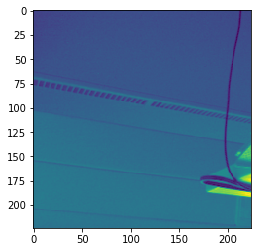

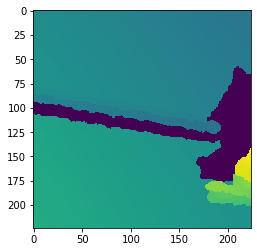

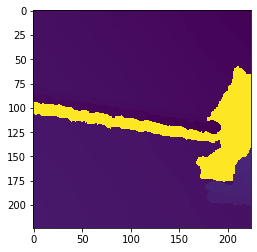

In [44]:
n=29
plt.imshow(img_l[n,3,0,:,:].cpu().detach().numpy())
plt.show()
plt.imshow(disp_l[n,0,:,:].cpu().detach().numpy())
plt.show()
plt.imshow(b_l[n,3,:,:].cpu().detach().numpy())
plt.show()

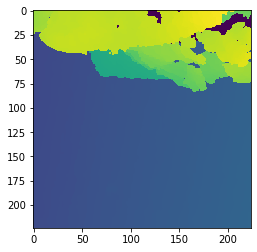

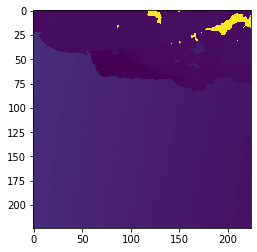

In [20]:
from dataloader import FoD500Loader
database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/'
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]
dataset_train = torch.utils.data.ConcatDataset(FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(FoD500_val)
TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=20, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=5, shuffle=False, drop_last=True)

train_log = logger.Logger( os.path.abspath('/scratch/lnw8px/depth-from-Focus-Defocus/DFV/'), name='ppp/train')
val_log = logger.Logger( os.path.abspath('/scratch/lnw8px/depth-from-Focus-Defocus/DFV/'), name='ppp/val')

model = DFFNet(clean=False,level=4, use_diff=True)
model = nn.DataParallel(model)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [24]:
disp_l=torch.empty((4,0,224,224))
f_l=torch.empty((0,5))
b_l=torch.empty((0,5,224,224))
for batch_idx, (img_stack,gt_disp,b,foc_dist) in enumerate(TrainImgLoader):
    disp_l=torch.cat((disp_l,disp),1)
    f_l=torch.cat((f_l,foc_dist),0)
    b_l=torch.cat((b_l,b),0)
    break

In [59]:
from models.submodule import *


In [27]:
foc_dist.shape

torch.Size([20, 5])

In [57]:
foc_ar=foc_dist.unsqueeze(dim=2).unsqueeze(dim=2)
foc_ar=torch.repeat_interleave(foc_ar,b.shape[-1],dim=-1).repeat_interleave(b.shape[-2],dim=-2)
bf=torch.cat((b,foc_ar),2)

In [58]:
foc_ar.shape,b.shape,bf.shape

(torch.Size([20, 5, 224, 224]),
 torch.Size([20, 5, 224, 224]),
 torch.Size([20, 5, 448, 224]))

In [22]:
img_stack_in   = Variable(torch.FloatTensor(img_stack))
gt_disp    = Variable(torch.FloatTensor(gt_disp))
img_stack, gt_disp, foc_dist = img_stack_in.cuda(),  gt_disp.cuda(), foc_dist.cuda()

#---------
max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
mask.detach_()
#----
model.train()
stacked, stds, _,cost3 = model(img_stack, foc_dist)

In [23]:
cost3[1].shape

torch.Size([20, 5, 224, 224])

In [5]:
torch.min(b_l),torch.max(b_l)

(tensor(4.7585e-09), tensor(inf))

In [6]:
torch.min(disp_l),torch.max(disp_l)

(tensor(0.), tensor(1.3633))

In [5]:
torch.min(f_l),torch.max(f_l)

(tensor(0.0714), tensor(1.))

In [4]:
img_stack_in.shape

torch.Size([4, 5, 3, 224, 224])

In [19]:
for batch_idx, (img_stack, gt_disp, b,foc_dist) in enumerate(TrainImgLoader):
    break

In [25]:
torch.min(1/(b+1)) , torch.max(1/(b+1))

(tensor(0.5028), tensor(1.))

In [24]:
torch.min(b) , torch.max(b)

(tensor(0.), tensor(0.9888))

In [17]:
img_stack_in   = Variable(torch.FloatTensor(img_stack))
gt_disp    = Variable(torch.FloatTensor(gt_disp))
img_stack, gt_disp, foc_dist = img_stack_in.cuda(),  gt_disp.cuda(), foc_dist.cuda()

#---------
max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
mask.detach_()
#----
model.eval()
stacked, stds, _,cost3 = model(img_stack, foc_dist)

In [18]:
foc_dist

tensor([[0.0667, 0.1000, 0.2000, 0.4667, 1.0000],
        [0.0667, 0.1000, 0.2000, 0.4667, 1.0000],
        [0.0667, 0.1000, 0.2000, 0.4667, 1.0000],
        [0.0667, 0.1000, 0.2000, 0.4667, 1.0000]], device='cuda:0')

In [12]:
max_val = torch.where(f_l>=100, torch.zeros_like(f_l), f_l)
torch.min(max_val),torch.max(max_val)

(tensor(0.0200), tensor(0.2800))

In [13]:
torch.zeros_like(f_l)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [6]:
img_stack_in=Variable(torch.FloatTensor(img_stack_in))
gt_disp=Variable(torch.FloatTensor(disp))
img_stack,gt_disp,foc_dist=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda()

#---------
max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
mask_tiled=torch.repeat_interleave(mask,repeats=5,dim=1)
mask.detach_()
mask_tiled.detach_()
mask.shape

torch.Size([4, 1, 224, 224])

In [11]:
torch.min(disp[mask]),torch.max(disp[mask])

(tensor(0.0845), tensor(0.8960))

In [3]:
blur=torch.empty((0,5,224,224))
disp=torch.empty((4,0,224,224))
for batch_idx, (img_stack, gt_disp,blur_stack,foc_dist) in enumerate(TrainImgLoader):
    blur=torch.cat((blur,blur_stack),0)
    disp=torch.cat((disp,gt_disp),1)

In [5]:
torch.min(blur),torch.max(blur)

(tensor(0.), tensor(1.))

In [4]:
torch.min(disp),torch.max(disp)

(tensor(0.), tensor(0.3956))

In [49]:
focus=1./(blur_stack+1)
torch.min(bb),torch.max(bb)

(tensor(0.5448), tensor(1.))

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]],


        [[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]],


        [[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True, 

In [17]:
class disparityregression(nn.Module):
    def __init__(self, divisor):
        super(disparityregression, self).__init__()
        self.divisor = divisor

    def forward(self, x, focal_dist=None, uncertainty=False):
        disp = focal_dist.unsqueeze(-1).unsqueeze(-1)
        out = torch.sum(x*disp,1, keepdim=True) * self.divisor

        if uncertainty:
            with torch.no_grad():
                std = torch.sqrt(torch.sum(x * (out - disp)**2, 1, keepdim=True))
            return out, std.detach()
        else:
            return out

In [18]:
disp_reg = disparityregression(1)

In [24]:
res=disp_reg(cost3.cpu(),foc_dist)
torch.min(res),torch.max(res)

(tensor(-31.1020, grad_fn=<MinBackward1>),
 tensor(23.3735, grad_fn=<MaxBackward1>))

In [28]:
torch.min(stacked[3]),torch.max(stacked[3])

(tensor(0.1000, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.5000, device='cuda:0', grad_fn=<MaxBackward1>))

In [4]:
optimizer.zero_grad()
beta_scale = 1 # smooth l1 do not have beta in 1.6, so we increase the input to and then scale back -- no significant improve according to our trials
stacked, stds, _,cost3 = model(img_stack, foc_dist)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
torch.max(1./(cost3+100))

tensor(0.0125, device='cuda:0', grad_fn=<MaxBackward1>)

In [8]:
torch.min(cost3),torch.max(cost3)

(tensor(-20.2014, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(33.3205, device='cuda:0', grad_fn=<MaxBackward1>))

In [10]:
floss,bloss,vis = train(img_stack, blur_stack,gt_disp, foc_dist)


In [11]:
floss,bloss

(tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2279, device='cuda:0', grad_fn=<MulBackward0>))

In [ ]:
model.train()
img_stack_in=Variable(torch.FloatTensor(img_stack_in))
gt_disp=Variable(torch.FloatTensor(disp))
img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()

#---------
mask = gt_disp > 0
mask.detach_()
#----

In [43]:
loss,vis=valid(img_stack, blur_stack,gt_disp, foc_dist)

In [36]:
loss

tensor(0.1194, device='cuda:0')

In [19]:
stacked, stds, _ ,cost_stacked= model(img_stack, foc_dist)

In [24]:
cost_stacked[0].shape,blur_stack.shape

(torch.Size([4, 5, 224, 224]), torch.Size([4, 5, 224, 224]))

In [30]:
cost_stacked[0].shape,blur_stack.shape

(torch.Size([4, 5, 224, 224]), torch.Size([4, 5, 224, 224]))

In [27]:
max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
mask.detach_()
mask.shape

torch.Size([4, 1, 224, 224])

In [32]:
mask_tiled=torch.repeat_interleave(mask,repeats=5,dim=1)
mask_tiled.shape

torch.Size([4, 5, 224, 224])

In [33]:
cost_stacked[0][mask_tiled]

tensor([ 0.1378,  0.1378,  0.1421,  ..., -3.1049, -3.1847, -3.1847],
       device='cuda:0', grad_fn=<IndexBackward>)

In [34]:
F.mse_loss(cost_stacked[0][mask_tiled],blur_stack[mask_tiled],reduction='none')

RuntimeError: expected device cuda:0 but got device cpu

In [42]:
def valid(img_stack_in, blur_stack,disp, foc_dist):
    model.eval()
    img_stack_in=Variable(torch.FloatTensor(img_stack_in))
    gt_disp=Variable(torch.FloatTensor(disp))
    img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()

    #---------
    mask = gt_disp > 0
    mask.detach_()
    #----
    with torch.no_grad():
        pred_disp, stds, _ ,cost= model(img_stack, foc_dist)
        loss = (F.mse_loss(pred_disp[mask] , gt_disp[mask] , reduction='mean')) # use MSE loss for val

    vis = {}
    vis['mask'] = mask.type(torch.float).detach().cpu()
    vis["pred"] = pred_disp.detach().cpu()

    return loss, vis

In [8]:
def train(img_stack_in, blur_stack,disp, foc_dist):
    model.train()
    img_stack_in=Variable(torch.FloatTensor(img_stack_in))
    gt_disp=Variable(torch.FloatTensor(disp))
    img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur_stack.cuda()
    focus=1./(blur_stack+1)

    #---------
    max_val = torch.where(foc_dist>=100, torch.zeros_like(foc_dist), foc_dist) # exclude padding value
    min_val = torch.where(foc_dist<=0, torch.ones_like(foc_dist)*10, foc_dist)  # exclude padding value
    mask = (gt_disp >= min_val.min(dim=1)[0].view(-1,1,1,1)) & (gt_disp <= max_val.max(dim=1)[0].view(-1,1,1,1)) #
    mask_tiled=torch.repeat_interleave(mask,repeats=5,dim=1)
    mask.detach_()
    mask_tiled.detach_()
    #----

    optimizer.zero_grad()
    beta_scale = 1 # smooth l1 do not have beta in 1.6, so we increase the input to and then scale back -- no significant improve according to our trials
    stacked, stds, _ ,cost_stacked= model(img_stack, foc_dist)


    floss,bloss=0,0
    lvl_w=[8./15, 4./15, 2./15, 1./15]
    for i, (pred, std) in enumerate(zip(stacked, stds)):
        _cur_floss = F.smooth_l1_loss(pred[mask] * beta_scale, gt_disp[mask]* beta_scale, reduction='none') / beta_scale
        floss = floss + lvl_w[i] * _cur_floss.mean()
        
        _cur_bloss=F.mse_loss(cost_stacked[0][mask_tiled],focus[mask_tiled],reduction='none')
        bloss = bloss + lvl_w[i] * _cur_bloss.mean()
    bloss=bloss*1e-2
    loss=floss+bloss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    vis={}
    vis['pred']=stacked[0].detach().cpu()
    vis['mask']=mask.type(torch.float).detach().cpu()
    flossvalue=floss.data
    blossvalue=bloss.data

    del stacked
    #del floss
    #del bloss
    del cost_stacked
    return floss,bloss,vis

In [38]:
import os
import numpy as np
from torch.utils.data import Dataset
import torchvision
import torch
from PIL import Image

from torchvision import transforms
import random
import numbers
import OpenEXR
from os import listdir, mkdir
from os.path import isfile, join, isdir
import cv2

def _abs_val(x):
    if isinstance(x, np.ndarray) or isinstance(x, float) or isinstance(x, int):
        return np.abs(x)
    else:
        return x.abs()
    
# to calculate circle of confusion
class CameraLens:
    def __init__(self, focal_length, sensor_size_full=(0, 0), resolution=(1, 1), aperture_diameter=None, f_number=None, depth_scale=1):
        self.focal_length = focal_length
        self.depth_scale = depth_scale
        self.sensor_size_full = sensor_size_full

        if aperture_diameter is not None:
            self.aperture_diameter = aperture_diameter
            self.f_number = (focal_length / aperture_diameter) if aperture_diameter != 0 else 0
        else:
            self.f_number = f_number
            self.aperture_diameter = focal_length / f_number

        if self.sensor_size_full is not None:
            self.resolution = resolution
            self.aspect_ratio = resolution[0] / resolution[1]
            self.sensor_size = [self.sensor_size_full[0], self.sensor_size_full[0] / self.aspect_ratio]
        else:
            self.resolution = None
            self.aspect_ratio = None
            self.sensor_size = None
            self.fov = None
            self.focal_length_pixel = None

    def _get_indep_fac(self, focus_distance):
        return (self.aperture_diameter * self.focal_length) / (focus_distance - self.focal_length)

    def get_coc(self, focus_distance, depth):
        if isinstance(focus_distance, torch.Tensor):
            for _ in range(len(depth.shape) - len(focus_distance.shape)):
                focus_distance = focus_distance.unsqueeze(-1)

        return (_abs_val(depth - focus_distance) / (depth+1e-4)) * self._get_indep_fac(focus_distance)
    

In [37]:
camera=CameraLens(2.9*1e-3,f_number=1)
camera

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import time
import models
from utils import logger, write_log
torch.backends.cudnn.benchmark=True
from glob import glob
import importlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from models import DFFNet

In [2]:
from dataloader import FoD500Loader
from dataloader import DDFF12Loader
from dataloader import CameraLens

database = '/scratch/lnw8px/depth-from-Focus-Defocus/data/my_ddff_trainVal.h5' 
DDFF12_train = DDFF12Loader(database, stack_key="stack_train", disp_key="disp_train", n_stack=5,
                             min_disp=0.02, max_disp=0.28)
DDFF12_val = DDFF12Loader(database, stack_key="stack_val", disp_key="disp_val", n_stack=5,
                                  min_disp=0.02, max_disp=0.28, b_test=False)
DDFF12_train, DDFF12_val = [DDFF12_train], [DDFF12_val]

database = '/scratch/lnw8px/depth-from-Focus-Defocus/defocus-net/data/fs_6/' 
FoD500_train, FoD500_val = FoD500Loader(database, n_stack=5, scale=1)
FoD500_train, FoD500_val =  [FoD500_train], [FoD500_val]

dataset_train = torch.utils.data.ConcatDataset(DDFF12_train+FoD500_train)
dataset_val = torch.utils.data.ConcatDataset(DDFF12_val) # we use the model perform better on  DDFF12_val

TrainImgLoader = torch.utils.data.DataLoader(dataset=dataset_train, num_workers=4, batch_size=20, shuffle=True, drop_last=True)
ValImgLoader = torch.utils.data.DataLoader(dataset=dataset_val, num_workers=1, batch_size=12, shuffle=False, drop_last=True)

In [ ]:
camera=CameraLens(9.5*1e-3,f_number=2)
camera.get_coc(0.0714, gt_disp.numpy())

In [33]:
torch.min(gt_disp),torch.max(gt_disp)

(tensor(0.0667), tensor(1.8936))

In [3]:
for batch_idx, (img_stack, gt_disp,blur,foc_dist) in enumerate(TrainImgLoader):
    break

In [4]:
model = DFFNet(clean=False,level=4, use_diff=True,dkernel=(3,3),dchlist=[10,64,1])
model = nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): DFFNet(
    (feature_extraction): FeatExactor(
      (encoder): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3

In [5]:
model.eval()
img_stack_in=Variable(torch.FloatTensor(img_stack))
gt_disp=Variable(torch.FloatTensor(gt_disp))
img_stack,gt_disp,foc_dist,blur_stack=img_stack_in.cuda(),gt_disp.cuda(),foc_dist.cuda(),blur.cuda()
focus=1./(blur_stack+1)

beta_scale = 1 # smooth l1 do not have beta in 1.6, so we increase the input to and then scale back -- no significant improve according to our trials
stacked, stds, _ ,cost_stacked,depth,conf= model(img_stack, foc_dist)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [6]:
conf

tensor([[[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 2.4022e-01,
           5.2960e-01, 5.2960e-01],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 2.4022e-01,
           5.2960e-01, 5.2960e-01],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 2.4022e-01,
           5.2960e-01, 5.2960e-01],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.7658e-01,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 7.5802e-01,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 7.5802e-01,
           1.0000e+00, 1.0000e+00]],

         [[1.9382e-21, 1.9382e-21, 1.9382e-21,  ..., 7.5978e-01,
           4.7040e-01, 4.7040e-01],
          [1.9382e-21, 1.9382e-21, 1.9382e-21,  ..., 7.5978e-01,
           4.7040e-01, 4.7040e-01],
          [1.9382e-21, 1.9382e-21, 1.9382e-21,  ..., 7.5978e-01,
           4.7040e-01, 4.7040e-01],
          ...,
          [1.2458e-21, 1.2458e-21, 1.2458e-21,  ..., 4.2342

In [17]:
sm=nn.Softmax(dim=1)
c=sm(conf)
c.shape

torch.Size([20, 2, 224, 224])

In [9]:
torch.max(conf[:,0,:,:]+conf[:,1,:,:])

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)

In [10]:
stacked.shape

torch.Size([20, 2, 224, 224])

In [10]:
s=stacked[0]
s.shape

torch.Size([20, 1, 224, 224])

In [15]:
total_depth=torch.cat((s,depth),dim=1)
pred=total_depth*conf

In [15]:
cost_stacked[0].shape

torch.Size([20, 5, 224, 224])

In [6]:
depth.shape

torch.Size([20, 1, 224, 224])

In [55]:
for batch_idx, (img_stack, gt_disp,blur,foc_dist) in enumerate(ValImgLoader):
    break

In [5]:
img_stack.shape,gt_disp.shape,blur.shape,foc_dist.shape

(torch.Size([20, 5, 3, 224, 224]),
 torch.Size([20, 1, 224, 224]),
 torch.Size([20, 5, 224, 224]),
 torch.Size([20, 5]))

In [6]:
img_stack.shape,gt_disp.shape,blur_stack.shape,foc_dist.shape

(torch.Size([12, 5, 3, 256, 256]),
 torch.Size([12, 1, 256, 256]),
 torch.Size([12, 5, 256, 256]),
 torch.Size([12, 5]))

In [3]:
blur=torch.empty((0,5,224,224))
disp=torch.empty((20,0,224,224))
for batch_idx, (img_stack, gt_disp,blur,foc_dist) in enumerate(TrainImgLoader):
    #blur=torch.cat((blur,blur_stack),0)
    disp=torch.cat((disp,gt_disp),1)

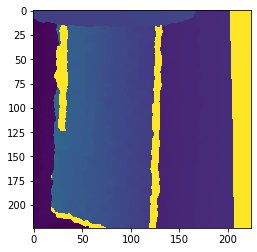

In [19]:
plt.imshow(blur_stack[7,0,:,:].cpu().detach().numpy())

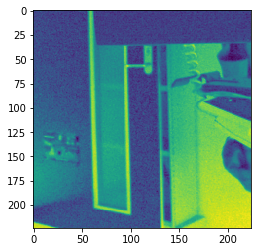

In [20]:
plt.imshow(img_stack[7,0,0,:,:].cpu().detach().numpy())

In [5]:
blur.shape

torch.Size([20, 5, 224, 224])

In [31]:
foc_ar[0,3,:,:]

tensor([[0.6905, 0.6905, 0.6905,  ..., 0.6905, 0.6905, 0.6905],
        [0.6905, 0.6905, 0.6905,  ..., 0.6905, 0.6905, 0.6905],
        [0.6905, 0.6905, 0.6905,  ..., 0.6905, 0.6905, 0.6905],
        ...,
        [0.6905, 0.6905, 0.6905,  ..., 0.6905, 0.6905, 0.6905],
        [0.6905, 0.6905, 0.6905,  ..., 0.6905, 0.6905, 0.6905],
        [0.6905, 0.6905, 0.6905,  ..., 0.6905, 0.6905, 0.6905]])

In [92]:
foc_ar=foc_dist.unsqueeze(dim=2).unsqueeze(dim=3).repeat_interleave(blur.shape[2],dim=2).repeat_interleave(blur.shape[3],dim=3)
bf=torch.cat((blur,foc_ar),dim=1)
bf.shape

torch.Size([20, 10, 224, 224])

In [7]:
model = DFFNet(clean=False,level=4, use_diff=True)
model = nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): DFFNet(
    (feature_extraction): FeatExactor(
      (encoder): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3

In [70]:
chlist=[10,64,32,16,1]

In [77]:
nn.Conv2d

torch.nn.modules.conv.Conv2d

In [112]:
class depthDecoder(nn.Module):
    def __init__(self,chlist,kernel_size,conv_stride=(1,1),pool_stride=(2,2),up=False, nstride=1,pool=False,bias=False):
        super(depthDecoder, self).__init__()
        self.layers=[]
        for i in range(len(chlist)-1):
            self.layers.append(nn.Conv2d(chlist[i],chlist[i+1],kernel_size,conv_stride,bias=bias))
            if pool:
                self.layers.append(nn.MaxPool2d(kernel_size,pool_stride))
                self.layers.append(nn.Upsample(size=(224,224)))
        self.convs = nn.Sequential(*self.layers)
        
    def forward(self,x):
        out=self.convs(x)
        return out

In [114]:
d=depthDecoder(chlist=[10,64],kernel_size=(3,3),pool=True)
print(d)
d(bf).shape

depthDecoder(
  (convs): Sequential(
    (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Upsample(size=(224, 224), mode=nearest)
  )
)


torch.Size([20, 64, 224, 224])

torch.Size([20, 64, 224, 224])

In [50]:
def sepConv3d(in_planes, out_planes, kernel_size, stride, pad,bias=False):
    if bias:
        return nn.Sequential(nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, padding=pad, stride=stride,bias=bias))
    else:
        return nn.Sequential(nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, padding=pad, stride=stride,bias=bias),
                         nn.BatchNorm3d(out_planes))

class sepConv3dBlock(nn.Module):
    '''
    Separable 3d convolution block as 2 separable convolutions and a projection
    layer
    '''
    def __init__(self, in_planes, out_planes, stride=(1,1,1)):
        super(sepConv3dBlock, self).__init__()
        if in_planes == out_planes and stride==(1,1,1):
            self.downsample = None
        else:
            self.downsample = projfeat3d(in_planes, out_planes,stride)
        self.conv1 = sepConv3d(in_planes, out_planes, 3, stride, 1)
        self.conv2 = sepConv3d(out_planes, out_planes, 3, (1,1,1), 1)


    def forward(self,x):
        out = F.relu(self.conv1(x),inplace=True)
        if self.downsample:
            x = self.downsample(x)
        out = F.relu(x + self.conv2(out),inplace=True)
        return out
    
class projfeat3d(nn.Module):
    '''
    Turn 3d projection into 2d projection
    '''
    def __init__(self, in_planes, out_planes, stride):
        super(projfeat3d, self).__init__()
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, out_planes, (1,1), padding=(0,0), stride=stride[:2],bias=False)
        self.bn = nn.BatchNorm2d(out_planes)

    def forward(self,x):
        b,c,d,h,w = x.size()
        x = self.conv1(x.view(b,c,d,h*w))
        x = self.bn(x)
        x = x.view(b,-1,d//self.stride[0],h,w)
        return x
    
class depthDecoder(nn.Module):
    def __init__(self, nconvs, inchannelF,channelF,stride=(1,1,1),up=False, nstride=1,pool=False):
        super(depthDecoder, self).__init__()
        self.convs = [sepConv3dBlock(inchannelF,channelF,stride=stride[0])]
        for i in range(1,nconvs):
            self.convs.append(sepConv3dBlock(channelF,channelF, stride=stride[i]))
        self.convs = nn.Sequential(*self.convs)

In [62]:
print(bf.shape)

torch.Size([20, 10, 224, 224])


In [64]:
sep=sepConv3dBlock(10,10)
sep(bf)

RuntimeError: Expected 5-dimensional input for 5-dimensional weight [10, 10, 3, 3, 3], but got 4-dimensional input of size [20, 10, 224, 224] instead

In [66]:
conv1 = sepConv3d(32, 32, 3, 1, 1)
down=projfeat3d(32, 32,[1])
x=torch.rand(5,32,3,224,224)
x=conv1(x)
print(x.shape)
down(x).shape

torch.Size([5, 32, 3, 224, 224])


torch.Size([5, 32, 3, 224, 224])

In [51]:
x=torch.rand(5,64,3,10,10)
sep=sepConv3dBlock(64,32)
sep(x).shape

torch.Size([5, 32, 3, 10, 10])
downsampling
torch.Size([5, 32, 3, 10, 10])


torch.Size([5, 32, 3, 10, 10])

In [43]:
foc_ar[0,0,:,:],blur[0,0,:,:]

(tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.1844, 0.1859, 0.1874,  ..., 0.0780, 0.0780, 0.0775],
         [0.1844, 0.1859, 0.1874,  ..., 0.0780, 0.0780, 0.0775],
         [0.1844, 0.1859, 0.1874,  ..., 0.0780, 0.0780, 0.0775]]))

In [62]:
bf[0,9,:,:]

tensor([[0.0714, 0.0714, 0.0714,  ..., 0.0714, 0.0714, 0.0714],
        [0.0714, 0.0714, 0.0714,  ..., 0.0714, 0.0714, 0.0714],
        [0.0714, 0.0714, 0.0714,  ..., 0.0714, 0.0714, 0.0714],
        ...,
        [0.0714, 0.0714, 0.0714,  ..., 0.0714, 0.0714, 0.0714],
        [0.0714, 0.0714, 0.0714,  ..., 0.0714, 0.0714, 0.0714],
        [0.0714, 0.0714, 0.0714,  ..., 0.0714, 0.0714, 0.0714]])

In [61]:
#! /usr/bin/python3

import os
import numpy as np
from torch.utils.data import Dataset
import torchvision
import torch
import h5py
from dataloader import CameraLens

# code adopted from https://github.com/soyers/ddff-pytorch/blob/master/python/ddff/dataproviders/datareaders/FocalStackDDFFH5Reader.py


class DDFF12Loader(Dataset):

    def __init__(self, hdf5_filename,  stack_key="stack_train", disp_key="disp_train", transform=None,
                 n_stack=10, min_disp=0.02, max_disp=0.28, b_test=False):
        """
        Args:
            root_dir_fs (string): Directory with all focal stacks of all image datasets.
            root_dir_depth (string): Directory with all depth images of all image datasets.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Disable opencv threading since it leads to deadlocks in PyTorch DataLoader
        self.hdf5 = h5py.File(hdf5_filename, 'r')
        self.stack_key = stack_key
        self.disp_key = disp_key
        self.max_n_stack = 10
        self.b_test = b_test
        self.camera=CameraLens(9.5*1e-3,f_number=2)
        self.max_disp=max_disp

        assert n_stack <= self.max_n_stack, 'DDFF12 has maximum 10 images per stack!'
        self.n_stack = n_stack
        self.disp_dist = torch.linspace(max_disp,min_disp, steps=self.max_n_stack)/max_disp

        if transform is None:
            if 'train' in self.stack_key:
                self.transform = self.__create_preprocessing(crop_size=(224, 224), cliprange=None, b_filp=True)
            else:
                transform_test = [DDFF12Loader.ToTensor(),
                                  DDFF12Loader.PadSamples((384, 576)),
                                  DDFF12Loader.Normalize(mean_input=[0.485, 0.456, 0.406],
                                                         std_input=[0.229, 0.224, 0.225])]
                self.transform =  torchvision.transforms.Compose(transform_test) #self.__create_preprocessing()
        else:
            self.transform = transform

    def __len__(self):
        return self.hdf5[self.stack_key].shape[0]

    def __getitem__(self, idx):
        # Create sample dict
        try:
            if 'test' in self.stack_key:
                sample =  {'input': self.hdf5[self.stack_key][idx].astype(float), 'output': np.ones([2,2])}
            else:
                sample = {'input': self.hdf5[self.stack_key][idx].astype(float), 'output': self.hdf5[self.disp_key][idx]}
        except:
            sample = None
            for _ in range(100):
                sample = {'input': self.hdf5[self.stack_key][idx].astype(float), 'output': self.hdf5[self.disp_key][idx]}
                if sample is not None:
                    break
            if sample is None:
                a =  self.hdf5[self.stack_key][idx].astype(float)
                b = self.hdf5[self.disp_key][idx]
                print(len(self.hdf5[self.stack_key]), idx, a is None, b is None)
                exit(1)
        sample['output']=sample['output']/self.max_disp   
        blur_list=[]
        for i in range(self.max_n_stack):
            blur = self.camera.get_coc(self.disp_dist[i].item(), sample['output'])
            blur = np.clip(blur, 0, 6.908e-4)/6.908e-4
            blur_list.append(blur)
        blur_list=np.stack(blur_list).squeeze()
        sample['blur']=blur_list

        # Transform sample with data augmentation transformers
        if self.transform :
            sample_out = self.transform(sample)

        # we do not experiment more than 10
        if self.n_stack < self.max_n_stack:
            if 'train' in self.disp_key:
                rand_idx = np.random.choice(self.max_n_stack, self.n_stack, replace=False) # this will shuffle order as well
                rand_idx = np.sort(rand_idx)
            else:
                rand_idx = np.linspace(0, 9, self.n_stack)

            out_imgs = sample_out['input'][rand_idx]
            out_disp = sample_out['output']
            disp_dist = self.disp_dist[rand_idx]
            blur_imgs=torch.tensor(sample_out['blur'])[rand_idx]
        else:
            out_imgs=sample_out['input']
            out_disp=sample_out['output']
            disp_dist=self.disp_dist
            blur_imgs=sample_out['blur']

        if 'val' in self.disp_key and (not self.b_test):
            out_disp = out_disp[:, :256, :256]
            out_imgs = out_imgs[:,:, :256, :256]
            blur_imgs=blur_imgs[:, :256, :256]
        
        
        return out_imgs,out_disp,blur_imgs,disp_dist
    
    def __create_preprocessing(self, crop_size=None, cliprange=[0.0202, 0.2825], mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225], b_filp=True):
        # The real data mean and std
        # mean [0.40134945 0.48795037 0.45252803], std [0.14938343, 0.15709994, 0.1496986]
        if b_filp:
            transform = [self.RandomFilp(), self.ToTensor()]
        else:
            transform = [self.ToTensor()]

        if cliprange is not None:
            transform += [self.ClipGroundTruth(cliprange[0], cliprange[1])]
        if crop_size is not None:
            transform += [self.RandomCrop(crop_size)]
        if mean is not None and std is not None:
            transform += [self.Normalize(mean_input=mean, std_input=std)]
        transform = torchvision.transforms.Compose(transform)
        return transform

    def get_stack_size(self):
        return self.__getitem__(0)['input'].shape[0]

    class ToTensor(object):
        """Convert ndarrays in sample to Tensors."""

        def __call__(self, sample):
            # Add color dimension to depth map
            sample['output'] = np.expand_dims(sample['output'], axis=0)
            # swap color axis because
            # numpy image: H x W x C
            # torch image: C X H X W
            sample['input'] = torch.from_numpy(sample['input'].transpose((0, 3, 1, 2))).float().div(255) #I add div 255
            sample['output'] = torch.from_numpy(sample['output']).float()
            return sample

    class Normalize(object):
        def __init__(self, mean_input, std_input, mean_output=None, std_output=None):
            self.mean_input = mean_input
            self.std_input = std_input
            self.mean_output = mean_output
            self.std_output = std_output

        def __call__(self, sample):
            img_lst = []
            samples = sample['input']

            for i, sample_input in enumerate(samples):
                img_lst.append(torchvision.transforms.functional.normalize(sample_input, mean=self.mean_input, std=self.std_input))
            input_images = torch.stack(img_lst)

            if self.mean_output is None or self.std_output is None:
                output_image = sample['output']
            else:
                output_image = torchvision.transforms.functional.normalize(sample['output'], mean=self.mean_output,
                                                                    std=self.std_output)


            return {'input': input_images, 'output': output_image,'blur':sample['blur']}

    class ClipGroundTruth(object):
        def __init__(self, lower_bound, upper_bound):
            self.lower_bound = lower_bound
            self.upper_bound = upper_bound

        def __call__(self, sample):
            sample['output'][sample['output'] < self.lower_bound] = 0.0
            sample['output'][sample['output'] > self.upper_bound] = 0.0
            return sample

    class RandomFilp(object):
        """ Randomly crop images
        """

        def __init__(self, ratio=0.5):
            self.ratio = ratio

        def __call__(self, sample):
            inputs, target,blur = sample['input'], sample['output'],sample['blur']

            # hori filp
            if np.random.binomial(1, self.ratio):
                inputs = inputs[:, :, ::-1]
                blur = blur[:, ::-1]
                target = target[:, ::-1]

            # vert flip
            if np.random.binomial(1, self.ratio):
                inputs = inputs[:, ::-1]
                blur = blur[::-1]
                target = target[::-1]

            return {'input': np.ascontiguousarray(inputs), 'output': np.ascontiguousarray(target),'blur':np.ascontiguousarray(blur)}


    class RandomCrop(object):
        def __init__(self, output_size, valid_crop_threshold=0.8):
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                self.output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                self.output_size = output_size
            self.valid_crop_threshold = valid_crop_threshold

        def __is_valid_crop(self, output_image, valid_pixel_cond=lambda x: x >= 0.01):
            valid_occurrances = valid_pixel_cond(output_image).sum()
            all_occurances = np.prod(output_image.shape)
            return (float(valid_occurrances) / float(all_occurances)) >= self.valid_crop_threshold

        def __call__(self, sample):
            h, w = sample['input'].shape[2:4]
            new_h, new_w = self.output_size

            # Generate list of possible random crops
            candidates = np.asarray([(x, y) for y in range(h - new_h) for x in range(w - new_w)])
            np.random.shuffle(candidates)

            # Iterate through candidates and choose forst valid crop
            for x, y in candidates:
                output_image = sample['output'][:, y:(y + new_h), x:(x + new_w)]
                if self.__is_valid_crop(output_image):
                    input_images = sample['input'][:, :, y:(y + new_h), x:(x + new_w)]
                    blur = sample['blur'][:, y:(y + new_h), x:(x + new_w)]
                    return {'input': input_images, 'output': output_image,'blur':blur}

            # No valid crop found. Return any crop
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)
            input_images =  sample['input'][:, :, top:(top + new_h), left:(left + new_w)]
            blur =  sample['blur'][:, top:(top + new_h), left:(left + new_w)]
            output_image = sample['output'][:, top:(top + new_h), left:(left + new_w)]
            return {'input': input_images, 'output': output_image,'blur':blur}

    class PadSamples(object):
        def __init__(self, output_size, ground_truth_pad_value=0.0):
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                self.output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                self.output_size = output_size
            self.ground_truth_pad_value = ground_truth_pad_value

        def __call__(self, sample):
            h, w = sample['input'].shape[2:4]
            new_h, new_w = self.output_size
            padh = np.int32(new_h - h)
            padw = np.int32(new_w - w)
            sample['input'] = torch.stack(
                [torch.from_numpy(np.pad(sample_input.numpy(), ((0, 0), (0, padh), (0, padw)), mode="reflect")).float()
                 for sample_input in sample['input']])
            sample['output'] = torch.from_numpy(
                np.pad(sample['output'].numpy(), ((0, 0), (0, padh), (0, padw)), mode="constant",
                       constant_values=self.ground_truth_pad_value)).float()

            return sample

    class RandomSubStack(object):
        def __init__(self, output_size):
            self.output_size = output_size

        def __call__(self, sample):
            sample['input'] = torch.stack([sample['input'][i] for i in
                                           np.random.choice(sample['input'].shape[0], self.output_size, replace=False)])
            return sample
